In [1]:
SEED = 42

Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [3]:
!pip install livelossplot -q

# Imports

In [4]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [5]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [6]:
dataset_df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

## Dataset info

In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105354 entries, 0 to 105353
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               105354 non-null  int64 
 1   followers_count  105354 non-null  int64 
 2   verified         105354 non-null  bool  
 3   reactions_count  105354 non-null  int64 
 4   retweet_count    105354 non-null  int64 
 5   text             105354 non-null  object
 6   source           105354 non-null  object
 7   description      89892 non-null   object
 8   replies_count    105354 non-null  int64 
 9   fake             105354 non-null  bool  
dtypes: bool(2), int64(5), object(3)
memory usage: 6.6+ MB


In [8]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True


In [9]:
dataset_df['fake'].value_counts()

False    72229
True     33125
Name: fake, dtype: int64

Duplicates and NaNs

In [10]:
dataset_df.duplicated().sum()

0

In [11]:
dataset_df.isnull().sum()

id                     0
followers_count        0
verified               0
reactions_count        0
retweet_count          0
text                   0
source                 0
description        15462
replies_count          0
fake                   0
dtype: int64

## Clean data

### Drop NaNs

In [12]:
dataset_df = df = dataset_df.fillna('')

## Map type to int

In [13]:
mapping = {False: 0, True: 1}
dataset_df['class'] = dataset_df['fake']
dataset_df = dataset_df.replace({'class': mapping})

## Merge title and text

In [14]:
dataset_df['text_combined'] = dataset_df['text'] + ' ' + dataset_df['description']

In [15]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake,class,text_combined
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,Michael Brown is the 17 yr old boy who was sho...
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid And how long before a...
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True,1,@d_m_elms @AmeenaGK they'll drag his entire hi...
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,@d_m_elms @jaythenerdkid or traces back some b...
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...


## Split dataset to train, val and test

Function

In [16]:
from sklearn.model_selection import train_test_split

# separate data into data and labels
features = dataset_df['text_combined']
targets = dataset_df['class']

# splitting data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=SEED)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=SEED)


In [17]:
predicted_frame = pd.DataFrame(X_test)
predicted_frame

,text_combined
82242,@huseinifaysal @DanieleRaineri AQ have mention...
5442,@elonjames Evening news will show why. Capture...
65369,@ChannelNewsAsia Marlene Kairouz MP | Member f...
11846,@TorontoStar R.I.P. ☀️
19284,“@abcnews: Two women have emerged from the Lin...
...,...
97817,@ChrChristensen @ioerror he was reduced to hun...
63413,Happy to oblige\n\n@demonnick666 @BasimaFaysal...
68755,@MariamVeiszadeh @OTOTGo @anggerwitasari Stay ...
10329,@cnnbrk praying that no more innocent people w...


### Convert X, y to tensors

In [18]:
X_train =  tf.constant(X_train, dtype=tf.string)
X_test =  tf.constant(X_test, dtype=tf.string)
X_val =  tf.constant(X_val, dtype=tf.string)

In [19]:
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')

# Model

## Parameters

In [28]:
BATCH_SIZE = 64
EPOCHS = 100
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 300
EMBEDDING_DIM = 75

## Vectorization layer

In [29]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize='lower',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(X_train, batch_size=BATCH_SIZE)

## Model architecture

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 300, 75)           7500000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              208896    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7,709,153
Trainable params: 7,709,153
Non-trainable params: 0
_________________________________________________________________


## Metrics

In [31]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [32]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS
)

## Callbacks

In [33]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "simple_lstm_default_params"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.001, restore_best_weights=True)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history_simple_lstm_default_params.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [34]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
1317/1317 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8484 - recall: 0.6958 - precision: 0.7962 - auc: 0.9186

1317/1317 [==============================] - 126s 88ms/step - loss: 0.3317 - accuracy: 0.8484 - recall: 0.6958 - precision: 0.7962 - auc: 0.9186 - val_loss: 0.2530 - val_accuracy: 0.8863 - val_recall: 0.7986 - val_precision: 0.8360 - val_auc: 0.9544
Epoch 2/100
1317/1317 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9332 - recall: 0.8958 - precision: 0.8921 - auc: 0.9820

1317/1317 [==============================] - 63s 48ms/step - loss: 0.1590 - accuracy: 0.9332 - recall: 0.8958 - precision: 0.8921 - auc: 0.9820 - val_loss: 0.2469 - val_accuracy: 0.8881 - val_recall: 0.8004 - val_precision: 0.8398 - val_auc: 0.9583
Epoch 3/100
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0962 - accuracy: 0.9596 - recall: 0.9369 - precision: 0.9346 - auc: 0.9933 - val_loss: 0.2652 - val_accuracy: 0.8874 - val_recall: 0.8246 - val_precision: 0.8216 - val_auc: 0.9550
Epoch 4/100
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0590 - accuracy: 0.9757 - recall: 0.9624 - precision: 0.9602 - auc: 0.9974 - val_loss: 0.3055 - val_accuracy: 0.8888 - val_recall: 0.8039 - val_precision: 0.8391 - val_auc: 0.9513
Epoch 5/100
1317/1317 [==============================] - 44s 34ms/step - loss: 0.0362 - accuracy: 0.9850 - recall: 0.9753 - precision: 0.9770 - auc: 0.9989 - val_loss: 0.4963 - val_accuracy: 0.8797 - val_recall: 0.7857 - val_prec

## Plot metrics history

In [35]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



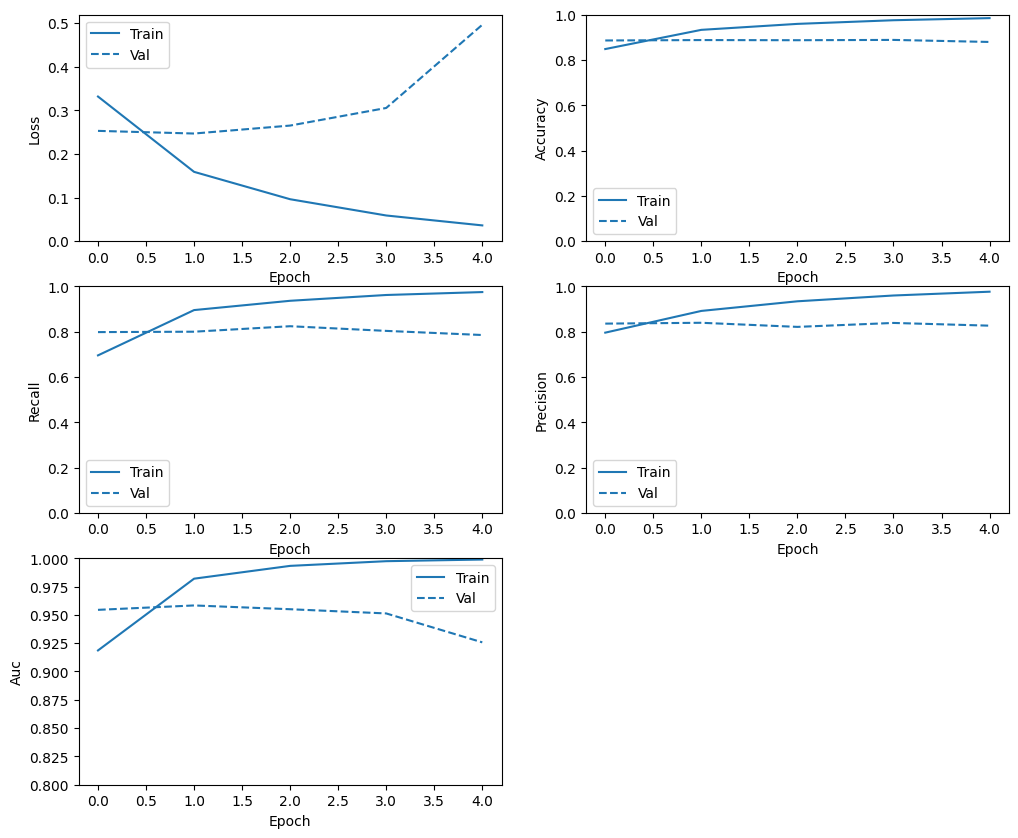

In [36]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [37]:
model.evaluate(X_test, y_test)

330/330 [==============================] - 4s 12ms/step - loss: 0.2453 - accuracy: 0.8912 - recall: 0.8081 - precision: 0.8382 - auc: 0.9587


[0.24525105953216553,
 0.8912197351455688,
 0.808135986328125,
 0.8381612300872803,
 0.9587416052818298]

 Load best model and save predictions

In [20]:
model = tf.keras.models.load_model(BEST_MODEL_DIR / "simple_lstm_default_params")

In [21]:
preds = model.predict(X_test)

330/330 [==============================] - 10s 9ms/step


In [26]:
predicted_frame['true'] = y_test
predicted_frame['preds'] = preds
predicted_frame.drop(columns='text_combined', inplace=True)
predicted_frame.to_csv('/content/drive/MyDrive/TAI/III/nlp/preds_dataframes/simple_lstm_default_params.csv')
predicted_frame

,true,preds
82242,0.0,0.009010
5442,1.0,0.693461
65369,0.0,0.170396
11846,1.0,0.825466
19284,1.0,0.993164
...,...,...
97817,0.0,0.000035
63413,0.0,0.003940
68755,0.0,0.000029
10329,1.0,0.357780
